## Lab Work 7: Ensemble Methods

This notebook builds on the same lecture of Foundations of Machine Learning. We'll focus on Ensemble Methods.

Important note: the steps shown here are not always the most efficient or the most "industry-approved." Their main purpose is pedagogical. So don't panic if something looks suboptimal—it's meant to be.

If you have questions (theoretical or practical), don't hesitate to bug your lecturer.

First the necessary imports:


In [1]:
# Basic libraries for data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn tools for preprocessing and modeling
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Baseline model
from sklearn.linear_model import LogisticRegression

# Ensemble models
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)
from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# Metrics
from sklearn.metrics import (
    balanced_accuracy_score,
    accuracy_score,
    classification_report,
    roc_auc_score,
)

### Step 0

Decision tree for regression: visualization. Generate synthetic data using a noisy Sin function and try to fit it with a decision tree regressor.

The criterion is reduce the variance
$\text{Var}_{\text{split}} = \frac{|S_L|}{|S|}\text{Var}(S_L) + \frac{|S_R|}{|S|}\text{Var}(S_R)$


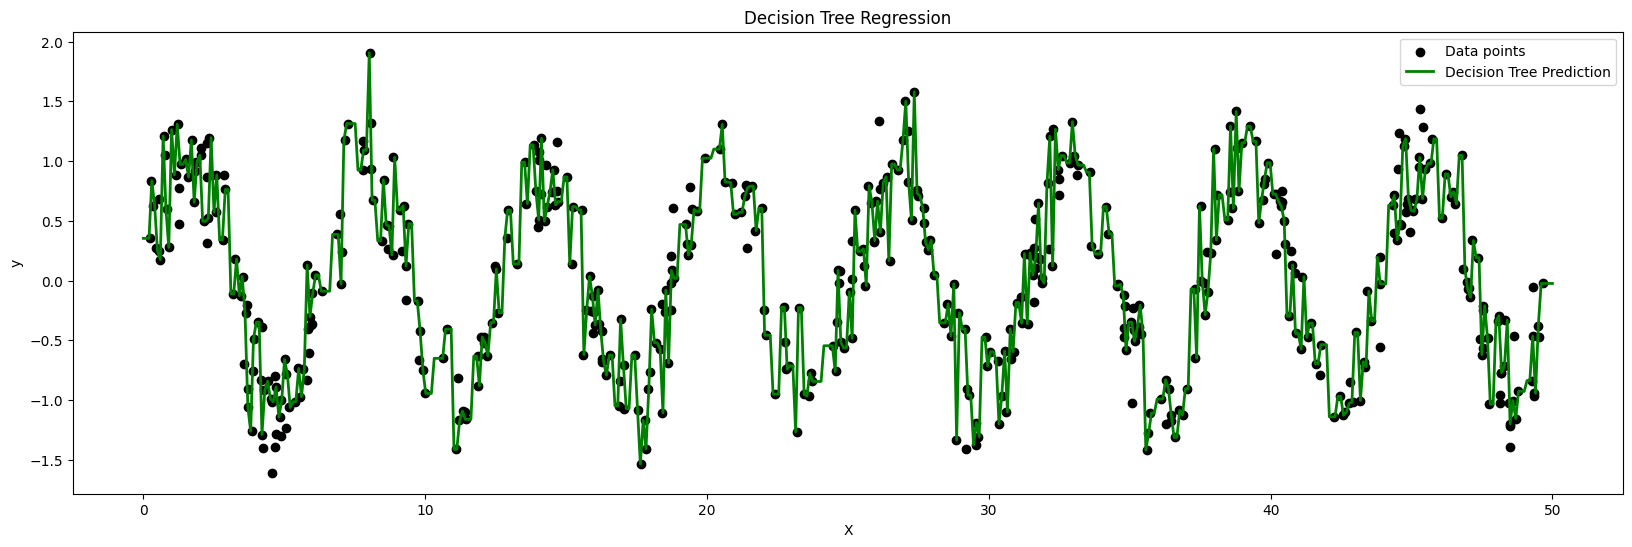

In [2]:
np.random.seed(42)  # For reproducibility
X = np.sort(50 * np.random.rand(500, 1), axis=0)  # Increased from 80 to 200
y = np.sin(X).ravel() + 0.3 * np.random.randn(500)  # Increased from 80 to 200

# fit
tree_reg = DecisionTreeRegressor(max_depth=25, random_state=42)
tree_reg.fit(X, y)

# predict
X_test = np.linspace(0.0, 50.0, 500).reshape(-1, 1)
y_pred = tree_reg.predict(X_test)

# assess
plt.figure(figsize=(20, 6))
plt.scatter(X, y, c="k", label="Data points")
plt.plot(X_test, y_pred, c="g", label="Decision Tree Prediction", linewidth=2)
plt.title("Decision Tree Regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

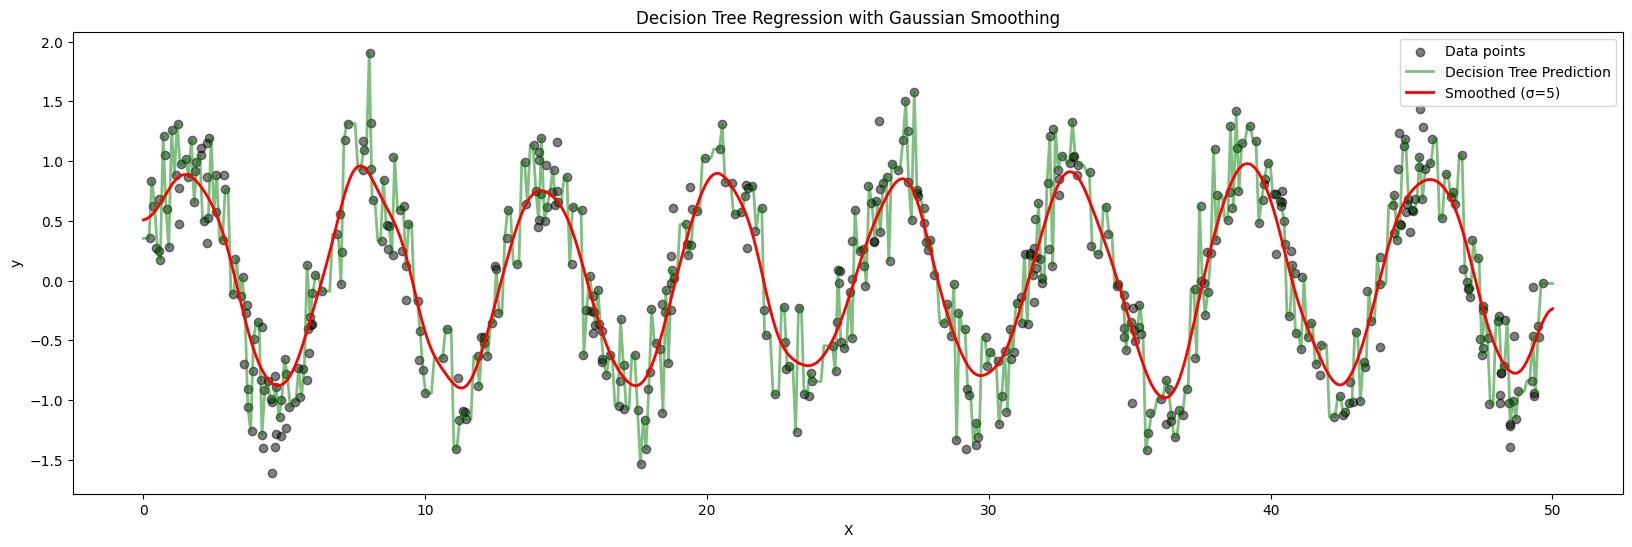

In [3]:
from scipy.ndimage import gaussian_filter1d

np.random.seed(42)  # For reproducibility
X = np.sort(50 * np.random.rand(500, 1), axis=0)
y = np.sin(X).ravel() + 0.3 * np.random.randn(500)

# fit
tree_reg = DecisionTreeRegressor(max_depth=25, random_state=42)
tree_reg.fit(X, y)

# predict
X_test = np.linspace(0.0, 50.0, 500).reshape(-1, 1)
y_pred = tree_reg.predict(X_test)

# Apply Gaussian smoothing (sigma controls smoothness)
sigma = 5  # Adjust this value: higher = smoother
y_pred_smooth = gaussian_filter1d(y_pred, sigma=sigma)

# assess
plt.figure(figsize=(20, 6))
plt.scatter(X, y, c="k", label="Data points", alpha=0.5)
plt.plot(
    X_test, y_pred, c="g", label="Decision Tree Prediction", linewidth=2, alpha=0.5
)
plt.plot(X_test, y_pred_smooth, c="r", label=f"Smoothed (σ={sigma})", linewidth=2)
plt.title("Decision Tree Regression with Gaussian Smoothing")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

### MAGIC Gamma Telescope Dataset (UCI)

This dataset comes from the MAGIC (Major Atmospheric Gamma Imaging Cherenkov) Telescope, used to study high-energy gamma rays. The objective is to classify whether each recorded event is: g → a gamma-ray event (signal), h → a hadronic shower (background noise).

Import the dataset from the UCI Machine Learning repository using `fetch_ucirepo` with id=159 and split features from target.


In [4]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

magic_gamma_test = fetch_ucirepo(id=159)

X = magic_gamma_test.data.features
y = magic_gamma_test.data.targets

if isinstance(y, pd.DataFrame):
    y = y.iloc[:, 0]

print(X.shape, y.shape)
display(X.head())
print("target distribution:")
print(y.value_counts())

(19020, 10) (19020,)


,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620


target distribution:
class
g    12332
h     6688
Name: count, dtype: int64


### Step 1

Build a preprocessing + Logistic Regression pipeline that will be the benchmark.
Since all features are numerical, just pass them through with a ColumnTransformer, then add a LogisticRegression classifier to the pipeline. Fill in the code below to complete the baseline model setup.


In [5]:
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
print("Numerical features:", numerical_features)

#
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_features),
    ]
)

# train test sppplit
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# base pipeline
base_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=10000, random_state=42)),
    ]
)

Numerical features: ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist']


### Step 2

The fundamental "trinity": fit your pipeline on the training set, generate predictions on the test set, and report performance metrics such as accuracy and the classification report.


In [6]:
# train
base_pipeline.fit(X_train, y_train)

# test
y_pred = base_pipeline.predict(X_test)

# report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           g       0.81      0.90      0.85      3700
           h       0.77      0.60      0.67      2006

    accuracy                           0.80      5706
   macro avg       0.79      0.75      0.76      5706
weighted avg       0.79      0.80      0.79      5706



### Step 3

Using `DecisionTreeClassifier` as introduced during the theoretical lecture, plot the performances on test and training in function of the depth as you did for the IRIS dataset


Best Test Balanced Accuracy: 0.8198 at max_depth=9


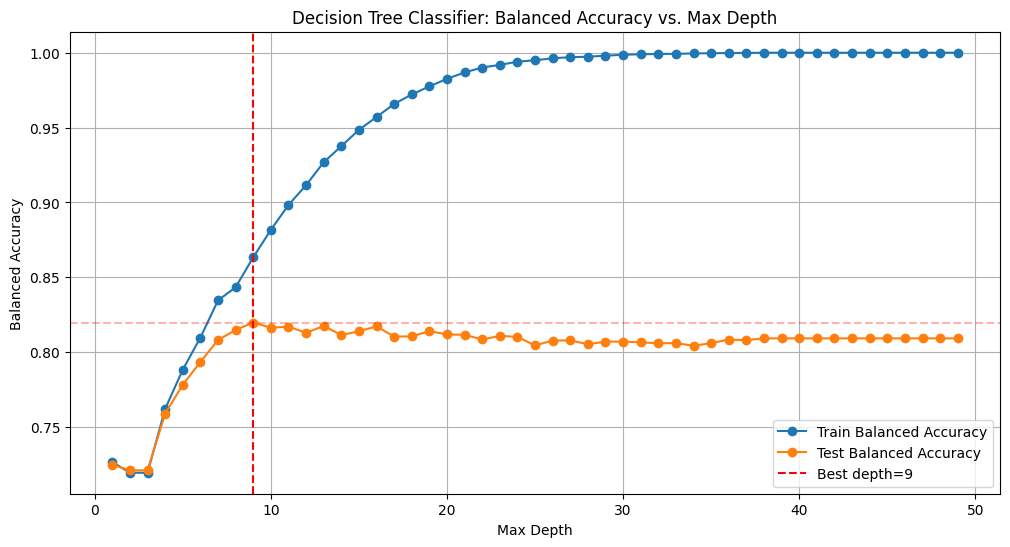

In [7]:
max_depths = list(range(1, 50))
train_scores = []
test_scores = []

for depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)

    train_scores.append(balanced_accuracy_score(y_train, dt.predict(X_train)))
    test_scores.append(balanced_accuracy_score(y_test, dt.predict(X_test)))

# Find best test score
best_test_score = max(test_scores)
best_depth = max_depths[test_scores.index(best_test_score)]

print(f"Best Test Balanced Accuracy: {best_test_score:.4f} at max_depth={best_depth}")

plt.figure(figsize=(12, 6))
plt.plot(max_depths, train_scores, label="Train Balanced Accuracy", marker="o")
plt.plot(max_depths, test_scores, label="Test Balanced Accuracy", marker="o")
plt.axvline(x=best_depth, color="r", linestyle="--", label=f"Best depth={best_depth}")
plt.axhline(y=best_test_score, color="r", linestyle="--", alpha=0.3)
plt.xlabel("Max Depth")
plt.ylabel("Balanced Accuracy")
plt.title("Decision Tree Classifier: Balanced Accuracy vs. Max Depth")
plt.legend()
plt.grid()
plt.show()

### Step 4: Bagging

Compare Bagging and Random Forests using decision trees as base learners. Both are ensemble methods, but they differ in how diversity is introduced among the trees:

1. Bagging (Bootstrap Aggregating)
   - Each tree is trained on a different bootstrap sample of the training data.
   - All features are considered when splitting nodes.
   - Final prediction is obtained by averaging (regression) or majority vote (classification).
   - Reduces variance compared to a single decision tree, but may still overfit if trees are deep.

Note: Bagging can be used with other base classifiers!

2. Random Forest. Builds on bagging, but adds feature randomness:
   - At each split, only a random subset of features is considered.
   - This additional randomness further decorrelates trees, usually improving generalization.


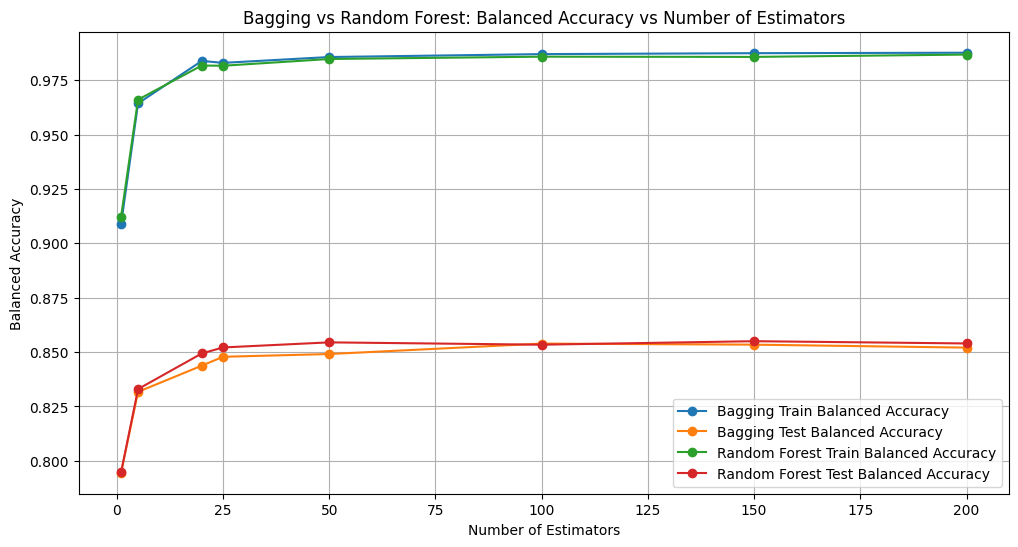

In [8]:
n_estimators_list = [1, 5, 20, 25, 50, 100, 150, 200]

# storage
bagging_bal_train = []
bagging_bal_test = []
rf_bal_train = []
rf_bal_test = []

for n in n_estimators_list:
    # bagging
    bagging_pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "classifier",
                BaggingClassifier(
                    estimator=DecisionTreeClassifier(max_depth=20, random_state=42),
                    n_estimators=n,
                    random_state=42,
                ),
            ),
        ]
    )
    bagging_pipeline.fit(X_train, y_train)
    # balanced accuracy
    bagging_bal_train.append(
        balanced_accuracy_score(y_train, bagging_pipeline.predict(X_train))
    )
    bagging_bal_test.append(
        balanced_accuracy_score(y_test, bagging_pipeline.predict(X_test))
    )

    rf_pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "classifier",
                RandomForestClassifier(n_estimators=n, max_depth=20, random_state=42),
            ),
        ]
    )
    rf_pipeline.fit(X_train, y_train)

    rf_bal_train.append(balanced_accuracy_score(y_train, rf_pipeline.predict(X_train)))
    rf_bal_test.append(balanced_accuracy_score(y_test, rf_pipeline.predict(X_test)))

# plot results
plt.figure(figsize=(12, 6))
plt.plot(
    n_estimators_list,
    bagging_bal_train,
    label="Bagging Train Balanced Accuracy",
    marker="o",
)
plt.plot(
    n_estimators_list,
    bagging_bal_test,
    label="Bagging Test Balanced Accuracy",
    marker="o",
)
plt.plot(
    n_estimators_list,
    rf_bal_train,
    label="Random Forest Train Balanced Accuracy",
    marker="o",
)
plt.plot(
    n_estimators_list,
    rf_bal_test,
    label="Random Forest Test Balanced Accuracy",
    marker="o",
)
plt.xlabel("Number of Estimators")
plt.ylabel("Balanced Accuracy")
plt.title("Bagging vs Random Forest: Balanced Accuracy vs Number of Estimators")
plt.legend()
plt.grid()
plt.show()

### difference between bagging and boosting is that boosting bagging is i paralel, you train n models on different datasets andn then do majority voting or average but with boosting it is sequentioal with nn steps improving at each step, the first model is explained by the second model


### Step 5: Boosting

Compare boosting methods using shallow decision trees as base learners. Boosting builds an ensemble sequentially, where each model focuses on improving the errors of the previous ones.

1. AdaBoost (adaptive boost)

   - Sequentially fits weak learners, giving more weight to misclassified samples.
   - Reduces bias of weak learners, but can be sensitive to noise.
   - Final prediction: Each weak learner votes, weighted by its accuracy. The class with the highest total vote is predicted.

2. Gradient Boosting

   - Sequentially fits models to residual errors of previous models using gradient descent.
   - More flexible than AdaBoost: supports regression, classification, and custom loss functions.
   - t each step j, we compute the pseudo-residuals as the negative gradient of the loss with respect to the current model $F_{j-1}(x)$: $r_i^{(j)} = - \left. \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} \right|_{F=F_{j-1}}$

3. XGBoost (no details)
   - Optimized, regularized version of gradient boosting.
   - Faster training via parallelization and handles missing values efficiently.
   - Often performs very well on large tabular datasets.


/Users/gasper/Documents/PSL/year_1/semster_1/Pratical-Machine-Learning/practical_ml/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [12:45:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gasper/Documents/PSL/year_1/semster_1/Pratical-Machine-Learning/practical_ml/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [12:45:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gasper/Documents/PSL/year_1/semster_1/Pratical-Machine-Learning/practical_ml/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [12:45:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/gasper/Documents/PSL/year_1

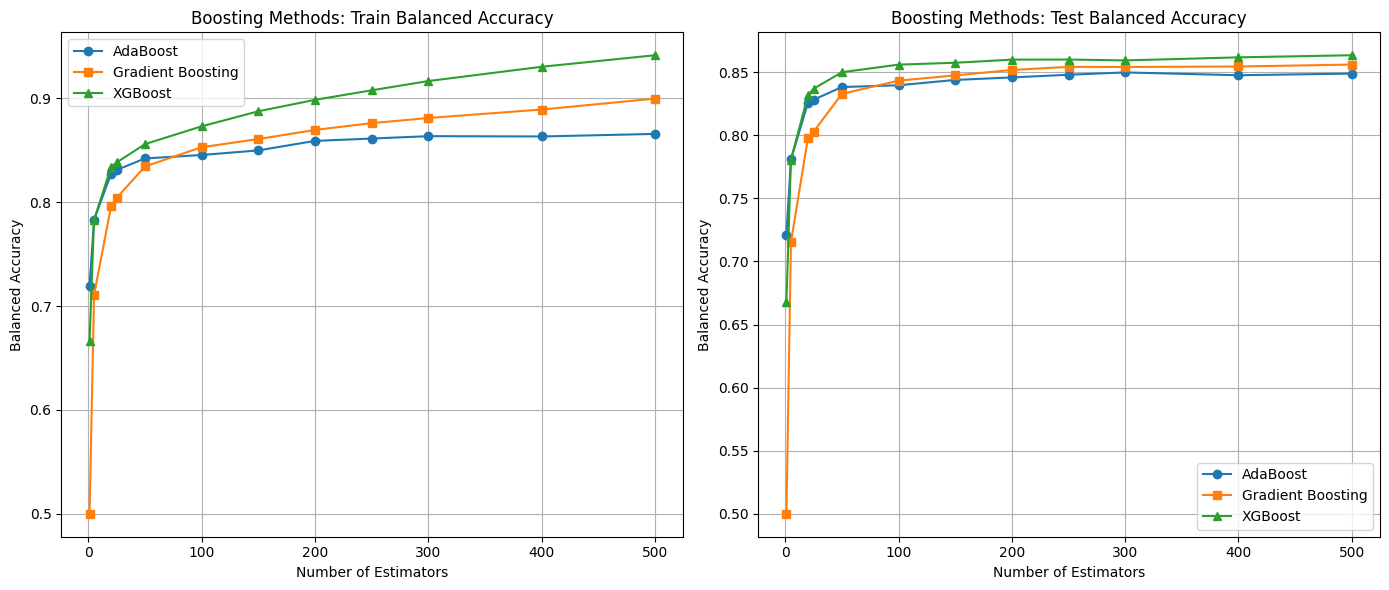

Best AdaBoost Test: 0.8498 at n=300
Best Gradient Boosting Test: 0.8560 at n=500
Best XGBoost Test: 0.8634 at n=500


In [10]:
n_estimators_list = [1, 5, 20, 25, 50, 100, 150, 200, 250, 300, 400, 500]

# storage
adaboost_bal_train = []
adaboost_bal_test = []
gb_bal_train = []
gb_bal_test = []
xgb_bal_train = []
xgb_bal_test = []

# Encode labels for XGBoost (requires numeric labels)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

for n in n_estimators_list:
    # AdaBoost
    adaboost_pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "classifier",
                AdaBoostClassifier(
                    estimator=DecisionTreeClassifier(max_depth=3, random_state=42),
                    n_estimators=n,
                    random_state=42,
                ),
            ),
        ]
    )
    adaboost_pipeline.fit(X_train, y_train)
    adaboost_bal_train.append(
        balanced_accuracy_score(y_train, adaboost_pipeline.predict(X_train))
    )
    adaboost_bal_test.append(
        balanced_accuracy_score(y_test, adaboost_pipeline.predict(X_test))
    )

    # Gradient Boosting
    gb_pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "classifier",
                GradientBoostingClassifier(
                    n_estimators=n, max_depth=3, random_state=42
                ),
            ),
        ]
    )
    gb_pipeline.fit(X_train, y_train)
    gb_bal_train.append(balanced_accuracy_score(y_train, gb_pipeline.predict(X_train)))
    gb_bal_test.append(balanced_accuracy_score(y_test, gb_pipeline.predict(X_test)))

    # XGBoost
    xgb_pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "classifier",
                XGBClassifier(
                    n_estimators=n,
                    max_depth=3,
                    random_state=42,
                    use_label_encoder=False,
                    eval_metric="logloss",
                ),
            ),
        ]
    )
    xgb_pipeline.fit(X_train, y_train_encoded)
    xgb_bal_train.append(
        balanced_accuracy_score(y_train_encoded, xgb_pipeline.predict(X_train))
    )
    xgb_bal_test.append(
        balanced_accuracy_score(y_test_encoded, xgb_pipeline.predict(X_test))
    )

# Plot results
plt.figure(figsize=(14, 6))

# Train scores
plt.subplot(1, 2, 1)
plt.plot(n_estimators_list, adaboost_bal_train, label="AdaBoost", marker="o")
plt.plot(n_estimators_list, gb_bal_train, label="Gradient Boosting", marker="s")
plt.plot(n_estimators_list, xgb_bal_train, label="XGBoost", marker="^")
plt.xlabel("Number of Estimators")
plt.ylabel("Balanced Accuracy")
plt.title("Boosting Methods: Train Balanced Accuracy")
plt.legend()
plt.grid()

# Test scores
plt.subplot(1, 2, 2)
plt.plot(n_estimators_list, adaboost_bal_test, label="AdaBoost", marker="o")
plt.plot(n_estimators_list, gb_bal_test, label="Gradient Boosting", marker="s")
plt.plot(n_estimators_list, xgb_bal_test, label="XGBoost", marker="^")
plt.xlabel("Number of Estimators")
plt.ylabel("Balanced Accuracy")
plt.title("Boosting Methods: Test Balanced Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Print best results
print(
    f"Best AdaBoost Test: {max(adaboost_bal_test):.4f} at n={n_estimators_list[adaboost_bal_test.index(max(adaboost_bal_test))]}"
)
print(
    f"Best Gradient Boosting Test: {max(gb_bal_test):.4f} at n={n_estimators_list[gb_bal_test.index(max(gb_bal_test))]}"
)
print(
    f"Best XGBoost Test: {max(xgb_bal_test):.4f} at n={n_estimators_list[xgb_bal_test.index(max(xgb_bal_test))]}"
)